<a href="https://colab.research.google.com/github/jeremiahmontebon/Deep-Learning-Based-Binary-Classification-of-Wrist-Fractures/blob/main/Binary_Classification_of_Wrist_Bone_Fractures_ResNet_50_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MOUNT DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**DATA DIRECTORY (training, validation, test)**

In [2]:
import tensorflow as tf

# Load the dataset for binary classification
directory_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Dataset/train-cropped',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=40,  # Optional, specify a seed for shuffling
    color_mode='rgb',  # Load images in grayscale/rgb mode
    labels='inferred',     # Optional, use 'inferred' to automatically infer the number of classes
    label_mode='binary'    # Specify the label mode as binary
)

directory_val = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Dataset/validation-cropped',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=40,  # Optional, specify a seed for shuffling
    color_mode='rgb',  # Load images in grayscale/rgb mode
    labels='inferred',     # Optional, use 'inferred' to automatically infer the number of classes
    label_mode='binary'    # Specify the label mode as binary
)

directory_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Dataset/test-cropped',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=40,  # Optional, specify a seed for shuffling
    color_mode='rgb',  # Load images in grayscale/rgb mode
    labels='inferred',     # Optional, use 'inferred' to automatically infer the number of classes
    label_mode='binary'    # Specify the label mode as binary
)

Found 489 files belonging to 2 classes.
Found 140 files belonging to 2 classes.
Found 70 files belonging to 2 classes.


**IMAGE PROCESSING AND DATA AUGMENTATION METHODS**



In [3]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score

def minimize_gray_noise(image):
    """
      Remove gray noise from image
    """
    gray_threshold = 125

    # Create a copy of the image to avoid modifying the original image
    modified_img = image.copy()
    # Iterate through each pixel and change gray colors to black
    for i in range(modified_img.shape[0]):
        for j in range(modified_img.shape[1]):
            pixel = modified_img[i, j]
            # Check pixel threshold
            if (pixel < gray_threshold):
                modified_img[i, j] = 0
    return modified_img

def histogram_equalization(image):
    """
      Enchance contrast of image
    """
    # Create a copy of the image to avoid modifying the original image
    modified_img = image.copy()

    # Do histogram equalization
    modified_img = cv2.equalizeHist(modified_img)

    return modified_img

def gray_to_rgb(image):
    """
      Convert image from gray to rgb
    """
    # Create a copy of the image to avoid modifying the original image
    modified_img = image.copy()

    modified_img = cv2.cvtColor(modified_img, cv2.COLOR_GRAY2RGB)

    return modified_img

def bgr_to_gray(image):
    """
      Convert image from rgb to gray
    """
    # Create a copy of the image to avoid modifying the original image
    modified_img = image.copy()

    modified_img = cv2.cvtColor(modified_img, cv2.COLOR_RGB2GRAY).astype(np.uint8)

    return modified_img

def inpaint_image(image):
    """
      Remove/Mask letter in an image
    """
    # Create a copy of the image to avoid modifying the original image
    modified_img = image.copy()

    _, mask = cv2.threshold(modified_img, 235, 255, cv2.THRESH_BINARY)

    # Inpaint the letters using the mask
    inpainted_image = cv2.inpaint(modified_img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inpainted_image

def extend_data(dataset):
    """
      Extract images and labels and store it in array
    """
    images_list = []
    labels_list = []
    for image_batch, label_batch in dataset:
        images_list.extend(image_batch.numpy())
        labels_list.extend(label_batch.numpy())
    return images_list, labels_list

def apply_transformations(image_list, image_label):
    """
      Create a copy of an image and do rotation and flipping
    """
    new_image_list = []
    new_image_label = []
    for image, label in zip(image_list, image_label):
        # Create a copy of the image to avoid modifying the original image
        modified_img = image.copy()

        # Expand channel since we have (224,224) shape and transofrm accepts only (x,x,1) or (x,x,3) we need to change axis
        modified_img = np.expand_dims(modified_img, axis=-1)
        modified_img = cv2.cvtColor(modified_img, cv2.COLOR_GRAY2RGB)

        #Rotation
        rotated_image = tf.image.rot90(modified_img, k=1).numpy()

        #Flipping
        flippedLF_image = tf.image.random_flip_left_right(modified_img).numpy()
        flippedUD_image = tf.image.random_flip_up_down(modified_img).numpy()

        # Append transformed images and labels to the new lists
        new_image_list.extend([rotated_image, flippedLF_image,flippedUD_image])
        new_image_label.extend([label, label,label])

    return new_image_list, new_image_label

def image_preprocessing(image):
    """
      Apply series of image processing
    """
    # Create a copy of the image to avoid modifying the original image
    modified_img = image.copy()

    modified_image = bgr_to_gray(modified_img)
    modified_image = histogram_equalization(modified_image)
    modified_image = inpaint_image(modified_image)
    modified_image = minimize_gray_noise(modified_image)
    return modified_image

In [4]:
# Extract images and labels

images_train, labels_train = extend_data(directory_train)
images_val, labels_val = extend_data(directory_val)
images_test, labels_test = extend_data(directory_test)

**APPLY IMAGE PROCESSING**

In [5]:
# Apply Image-Preprocessing

pre_processed_images = []

for idx in range(len(images_train)):
    modified_image = bgr_to_gray(images_train[idx])
    modified_image = histogram_equalization(modified_image)
    modified_image = inpaint_image(modified_image)
    modified_image = minimize_gray_noise(modified_image)
    pre_processed_images.append(modified_image) # Append the modified image to the new list

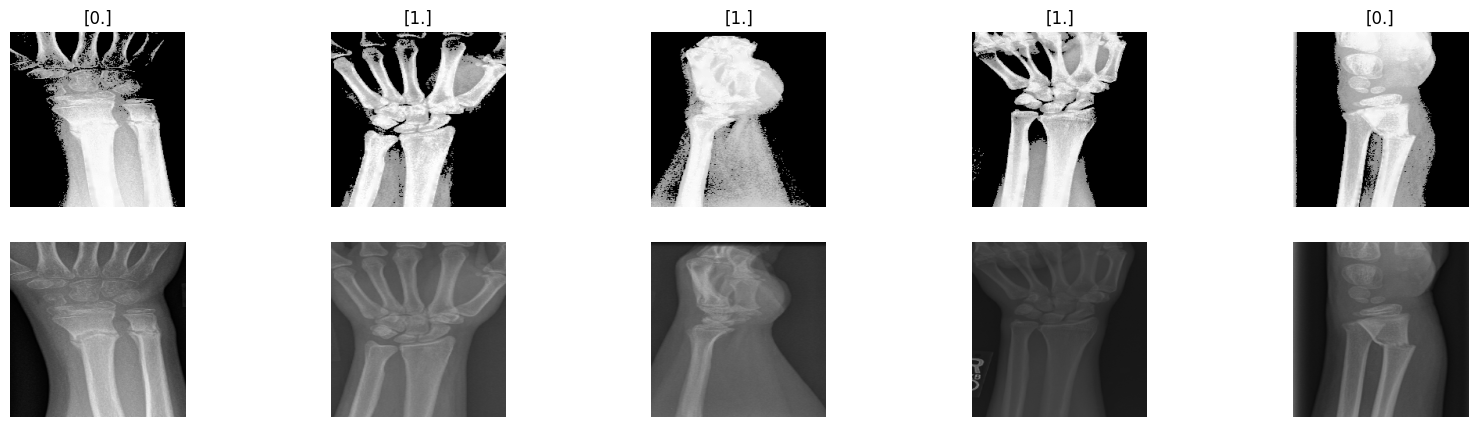

In [6]:
import matplotlib.pyplot as plt

# Plot 5 images
num_images_to_plot = 5
fig, axes = plt.subplots(2, num_images_to_plot, figsize=(20, 5))

# Iterate over the first 5 images in the array
for i in range(num_images_to_plot):
    # Get the i-th image from the array
    image = pre_processed_images[i]
    image2 = images_train[i].astype('float32') / 255.0

    # Plot the first image (modified)
    axes[0, i].imshow(image, cmap='gray')  # Specify cmap='gray' for grayscale images
    axes[0, i].axis('off')
    axes[0, i].set_title(labels_train[i])  # Add title to the modified image subplot
    # Plot the second image (original)
    axes[1, i].imshow(image2)
    axes[1, i].axis('off')

plt.show()


**APPLY DATA-AUGMENTATION**

In [7]:
# Apply Data Augmentation

transformed_image_list, transformed_image_label = apply_transformations(pre_processed_images, labels_train)

In [8]:
#Combine the original image-processing and data augmented

images_train.extend(transformed_image_list)
labels_train.extend(transformed_image_label)

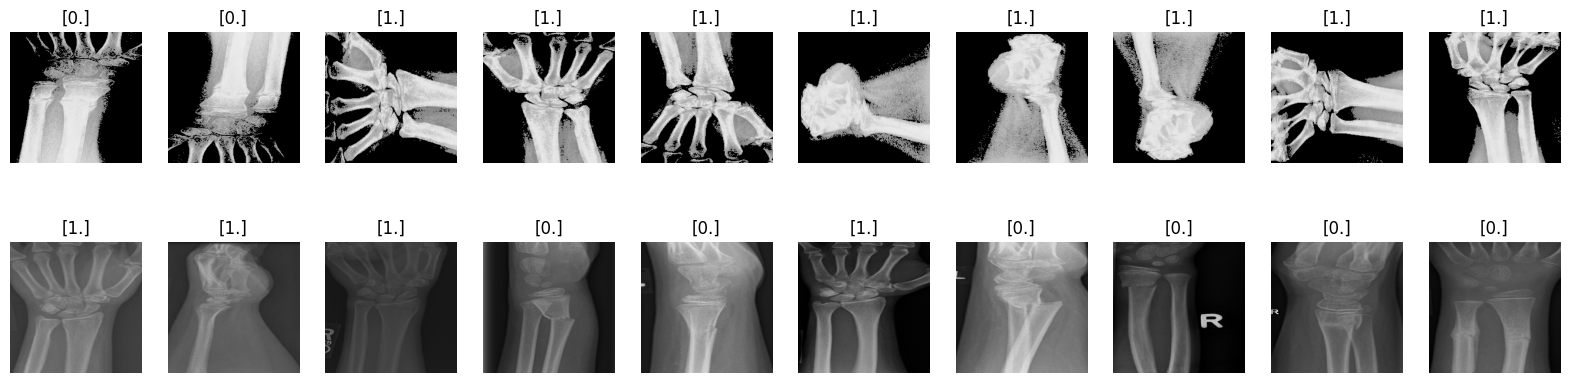

In [9]:
start_index = 1
num_images_to_plot = 10
fig, axes = plt.subplots(2, num_images_to_plot, figsize=(20, 5))

# Iterate over the first 5 images in the array
for i in range(start_index, num_images_to_plot+start_index):
    # Get the i-th image from the array
    image = transformed_image_list[i].astype('float32') / 255.0
    image2 = images_train[i].astype('float32') / 255.0

    # Plot the first image (modified)
    axes[0, i - start_index].imshow(image, cmap='gray')  # Specify cmap='gray' for grayscale images
    axes[0, i - start_index].axis('off')
    axes[0, i - start_index].set_title(transformed_image_label[i])  # Add title to the modified image subplot

    # Plot the second image (original)
    axes[1, i - start_index].imshow(image2, cmap='gray')
    axes[1, i - start_index].axis('off')
    axes[1, i - start_index].set_title(labels_train[i])  # Add title to the modified image subplot
plt.show()


**DATA NORMALIZATION**

In [10]:
for image in range(len(images_train)):
    images_train[image] = images_train[image].astype(np.float32)
    images_train[image] /= 255.0

**TRANSFER LEARNING**

In [11]:
# Do the pre-processing on validation and test
modified_images_val = []

for idx in range(len(images_val)):
    modified_image = image_preprocessing(images_val[idx])
    modified_image = gray_to_rgb(modified_image)
    modified_images_val.append(modified_image) # Append the modified image to the new list

In [12]:
for image in range(len(modified_images_val)):
    modified_images_val[image] = modified_images_val[image].astype(np.float32)
    modified_images_val[image] /= 255.0

**Resnet-50 MODEL CREATION**

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras as K
from tensorflow.keras import layers, Sequential

resnet_model = Sequential()
base_model = tf.keras.applications.ResNet50(include_top = False,
                                                  input_shape = (224,224,3),
                                                  pooling='avg',
                                                  weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

resnet_model.add(base_model)

#Add fully connected layers

resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(1024, activation='relu'))
resnet_model.add(K.layers.BatchNormalization())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(K.layers.Dropout(0.3))
resnet_model.add(K.layers.BatchNormalization())
resnet_model.add(layers.Dense(256, activation='relu'))
resnet_model.add(K.layers.Dropout(0.3))
resnet_model.add(K.layers.BatchNormalization())
resnet_model.add(layers.Dense(1, activation='sigmoid'))

#Compile and train the model
resnet_model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

94765736/94765736 [==============================] - 1s 0us/step


In [14]:
print(resnet_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

**TRAIN MODEL**

In [15]:
#Convert first to tensorflow dataset/generator

images_train_array = np.array(images_train)
labels_train_array = np.array(labels_train)

images_val_array = np.array(modified_images_val)
labels_val_array = np.array(labels_val)

#Expand dimension
images_train_array = np.expand_dims(images_train_array, axis=-1)
images_val_array = np.expand_dims(images_val_array, axis=-1)

#Remove the extra dimension result in np.expanad is (x, 224, 224, 3, 1) remove 1
images_train_array = np.squeeze(images_train_array, axis=-1)
images_val_array = np.squeeze(images_val_array, axis=-1)

#Create a Tensorflow dataset from the arrays
dataset_train = tf.data.Dataset.from_tensor_slices((images_train_array, labels_train_array))
dataset_val = tf.data.Dataset.from_tensor_slices((images_val_array, labels_val_array))

#Shuffle
batch_size = 32
dataset_train = dataset_train.shuffle(buffer_size=len(images_train_array)).batch(batch_size)
dataset_val = dataset_val.batch(batch_size)

In [16]:
# Define callbacks
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
checkpoint = K.callbacks.ModelCheckpoint(filepath='ResNet50_model.h5', monitor='val_loss', save_best_only=True)
csv_logger = K.callbacks.CSVLogger('training_history_ResNet50.csv')  # Save training history to a CSV file
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

#Train the InceptionModel
history = resnet_model.fit(dataset_train, epochs = 100,
                    validation_data = dataset_val,
                    callbacks=[early_stopping, checkpoint, csv_logger, reduce_lr])

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.7040 - precision: 0.7056 - recall: 0.7020

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 23s 170ms/step - loss: 0.5869 - accuracy: 0.7040 - precision: 0.7056 - recall: 0.7020 - val_loss: 0.5583 - val_accuracy: 0.7786 - val_precision: 0.8545 - val_recall: 0.6714 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - 6s 103ms/step - loss: 0.5172 - accuracy: 0.7546 - precision: 0.7583 - recall: 0.7490 - val_loss: 0.6566 - val_accuracy: 0.6214 - val_precision: 0.5702 - val_recall: 0.9857 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - 7s 111ms/step - loss: 0.4453 - accuracy: 0.7919 - precision: 0.8000 - recall: 0.7796 - val_loss: 0.5505 - val_accuracy: 0.6643 - val_precision: 0.6018 - val_recall: 0.9714 - lr: 0.0010
Epoch 4/100
62/62 [==============================] - 7s 108ms/step - loss: 0.4017 - accuracy: 0.8144 - precision: 0.8082 - recall: 0.8255 - val_loss: 0.8676 - val_accuracy: 0.5143 - val_precision: 0.5074 - val_recall: 0.9857 - lr: 0.0010
Epoch 5/100
62/62 [==============================] - 6s 101

**DATA VISUALIZATION**

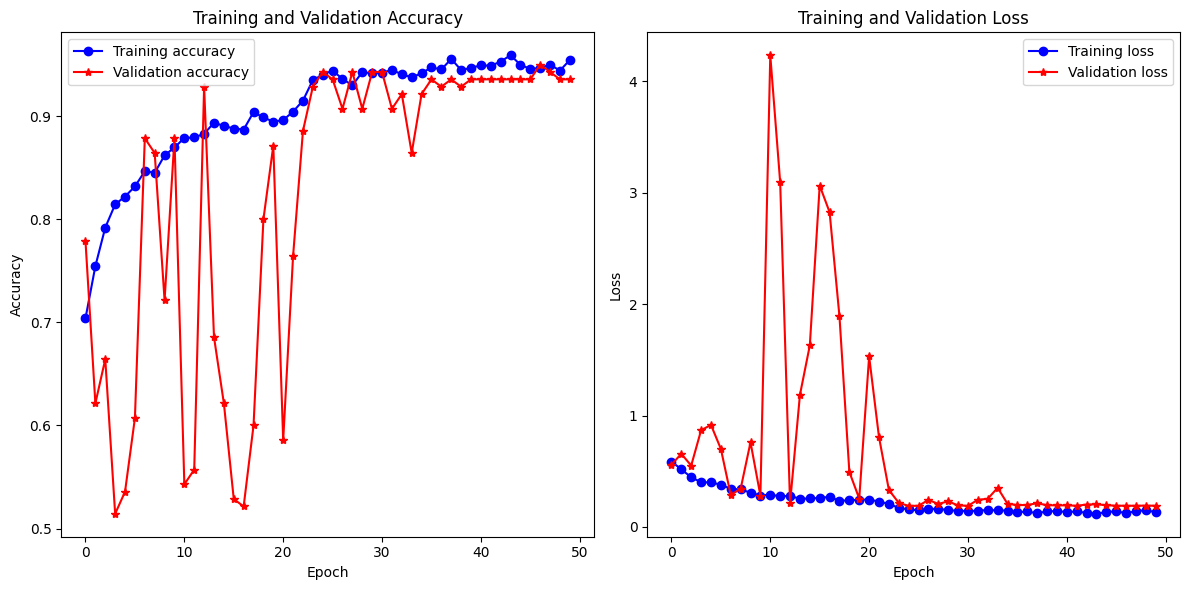

In [17]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training history from the CSV file
history_df = pd.read_csv('/content/training_history_ResNet50.csv')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['accuracy'], 'bo-', label='Training accuracy')
plt.plot(history_df['epoch'], history_df['val_accuracy'], 'r*-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['loss'], 'bo-', label='Training loss')
plt.plot(history_df['epoch'], history_df['val_loss'], 'r*-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

5/5 [==============================] - 1s 107ms/step
Precision: 0.918918918918919
Recall: 0.9714285714285714
Accuracy: 0.9428571428571428
F1 Score: 0.9444444444444445


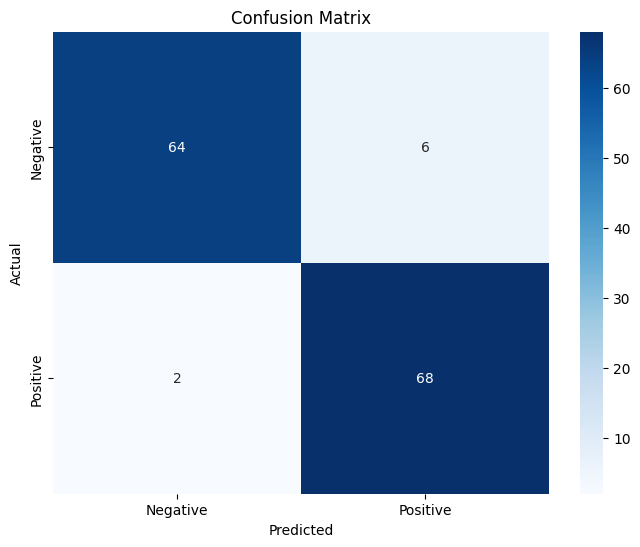

In [18]:
#Change the directory to your own
model = load_model('/content/ResNet50_model.h5')

y_pred = model.predict(dataset_val)
y_predicted_classes = (y_pred > 0.5).astype(int).flatten()
precision = precision_score(labels_val, y_predicted_classes)
recall = recall_score(labels_val, y_predicted_classes)
accuracy = accuracy_score(labels_val, y_predicted_classes)
f1 = f1_score(labels_val, y_predicted_classes)

# Print the results
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


cm = confusion_matrix(labels_val, y_predicted_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()